In [1]:
# Libraries

import json
import numpy
import os
import platform
import shutil
import sys

In [2]:
# Root directory

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Tune

from ray.air                  import CheckpointConfig
from ray.air                  import FailureConfig
from ray.air                  import RunConfig
from ray.tune                 import JupyterNotebookReporter
from ray.tune                 import TuneConfig
from ray.tune                 import Tuner
from ray.tune.logger          import CSVLoggerCallback
from ray.tune.schedulers      import ASHAScheduler
from ray.tune.search          import ConcurrencyLimiter
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.hyperopt import HyperOptSearch

from ray import tune

In [4]:
# Code

from source.python.cnn import raytune as cnn_raytune
from source.python.cnn import core    as cnn_core
from source.python.io  import loader  as data_loader

# 1. Setup

In [5]:
# Setup model to tune

MODEL_NAME = 'zrimec2020'
MODEL_TYPE = 'r'

In [6]:
# Setup some directory paths.

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp06-tuner', MODEL_NAME)
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_TUNER = os.path.join(RES,      'tuner')
RES_NBP04 = os.path.join(OUT,      'nbp04-feature')
RES_NBP05 = os.path.join(OUT,      'nbp05-target')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_TUNER}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\zrimec2020
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\zrimec2020\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\tuner
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target


In [7]:
# Load the inputs and ouputs

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-order.json')
)

In [8]:
# Lock random

RANDOM_SEED = cnn_core.lock_random(
	generate_seed = True
)

print('Random seed : {}'.format(RANDOM_SEED))

Random seed : 413461323


In [9]:
# System and device

DEVICE = cnn_core.get_device(only_cpu = False)
SYSTEM = cnn_core.get_system_info()

for key, value in SYSTEM.items() :
	print('{:16s} : {}'.format(key, value))

platform_python  : 3.10.7
platform_system  : Windows
platform_release : 10
platform_version : 10.0.19044
cpu_name         : N/A
cpu_count        : 12
cuda_name        : NVIDIA GeForce RTX 3060 Ti
cuda_available   : True
cuda_devices     : 1
memory_total     : 31.924 GB
memory_available : 23.723 GB


# 2. CNN Regression

## 2.1 Config

In [10]:
# Define basic data parameters

core_config = {
	'random_seed' : RANDOM_SEED,
	'device'      : DEVICE,
	'model_name'  : MODEL_NAME + MODEL_TYPE,
	'expand_dims' : None,
	'epochs'      : 10,
	'samples'     : 20,
	'notebook'    : True,
	'checkpoint'  : False,

	'split_size' : {
		'valid' : 0.2,
		'test'  : 0.2
	},
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0' : 'tissue',
		'group1' : 'tissue-mean',
		'length' : 8
	},
	'files' : {
		'sequences' : lambda : data_loader.load_fasta(filename = os.path.join(RES_NBP04, 'features-bp2150.fasta'), to_string = True),
		'frequency' : lambda : data_loader.load_npz(filename = os.path.join(RES_NBP04, 'features-frequency.npz')),
		'stability' : lambda : data_loader.load_npz(filename = os.path.join(RES_NBP04, 'features-stability.npz')),
		'values'    : lambda : data_loader.load_labels(filename = os.path.join(RES_NBP05, 'target-values.json'), to_numpy = True),
		'order'     : lambda : data_loader.load_labels(filename = os.path.join(RES_NBP05, 'target-order.json'))
	}
}

In [11]:
# Ensure correct

core_config['output']['length'] = len(tpm_order[core_config['output']['group0']])

if core_config['model_name'].startswith('washburn2019') :
	core_config['expand_dims'] = 0

## 2.2 Search Space

In [12]:
# Define optimizer parameters

optimizer_name     = tune.choice(['adam', 'sgd'])
optimizer_lr       = tune.loguniform(1e-5, 1e-2)
optimizer_decay    = tune.uniform(0.0, 0.10)
optimizer_momentum = tune.uniform(0.0, 0.99)

In [13]:
# Define scheduler parameters

scheduler_name             = tune.choice(['constant', 'step', 'plateau', 'linear', 'exponential'])
scheduler_plateau_factor   = tune.uniform(0.1, 0.5)
scheduler_plateau_patience = tune.randint(1, 20)
scheduler_step_factor      = tune.uniform(0.1, 0.5)
scheduler_step_patience    = tune.randint(1, 20)
scheduler_linear_factor    = tune.uniform(1e-05, 1e-01)
scheduler_exp_factor       = tune.uniform(0.950, 0.999)

In [14]:
# Define model parameters

model_dropout  = tune.quniform(0.0, 0.5, 0.01)

conv1_kernels  = [5, 11, 21, 31, 41]
conv1_filters  = [32, 64, 128, 256]

convx_kernels  = [5, 11, 21, 31, 41]
convx_padding  = ['same', 'none']
convx_filters  = [32, 64, 128, 256]
convx_dilation = [1, 2, 4]

poolx_kernels  = [3, 5, 9]
poolx_padding  = ['same', 'none']

fcx_features = [64, 128, 256, 512]

if core_config['model_name'].startswith('washburn2019') :
	conv1_kernels = [(4, x) for x in conv1_kernels]
	convx_kernels = [(1, x) for x in convx_kernels]
	poolx_kernels = [(1, x) for x in poolx_kernels]

In [15]:
# Define search space (tested with zrimec2020 and washburn2019)

param_space = dict()

# Dataset
param_space['dataset/batch_size'] = tune.choice([32, 64, 128])

# Optimizer
param_space['optimizer/name']     = optimizer_name
param_space['optimizer/lr']       = optimizer_lr
param_space['optimizer/decay']    = optimizer_decay
param_space['optimizer/momentum'] = optimizer_momentum

# Scheduler
param_space['scheduler/name']               = scheduler_name
param_space['scheduler/plateau/factor']     = scheduler_plateau_factor
param_space['scheduler/plateau/patience']   = scheduler_plateau_patience
param_space['scheduler/linear/factor']      = scheduler_linear_factor
param_space['scheduler/step/factor']        = scheduler_step_factor
param_space['scheduler/step/patience']      = scheduler_step_patience
param_space['scheduler/exponential/factor'] = scheduler_exp_factor

# Model
param_space['model/dropout'] = model_dropout

# Convolution
param_space['model/conv1/filters']  = tune.choice(conv1_filters)
param_space['model/conv1/kernel']   = tune.choice(conv1_kernels)
param_space['model/conv1/padding']  = 'none'
param_space['model/conv1/dilation'] = 1
param_space['model/conv2/filters']  = tune.choice(convx_filters)
param_space['model/conv2/kernel']   = tune.choice(convx_kernels)
param_space['model/conv2/padding']  = tune.choice(convx_padding)
param_space['model/conv2/dilation'] = 1
param_space['model/conv3/filters']  = tune.choice(convx_filters)
param_space['model/conv3/kernel']   = tune.choice(convx_kernels)
param_space['model/conv3/padding']  = tune.choice(convx_padding)
param_space['model/conv3/dilation'] = 1

if core_config['model_name'].startswith('washburn2019') :
	param_space['model/conv4/filters']  = tune.choice(convx_filters)
	param_space['model/conv4/kernel']   = tune.choice(convx_kernels)
	param_space['model/conv4/padding']  = tune.choice(convx_padding)
	param_space['model/conv4/dilation'] = 1
	param_space['model/conv5/filters']  = tune.choice(convx_filters)
	param_space['model/conv5/kernel']   = tune.choice(convx_kernels)
	param_space['model/conv5/padding']  = tune.choice(convx_padding)
	param_space['model/conv5/dilation'] = 1
	param_space['model/conv6/filters']  = tune.choice(convx_filters)
	param_space['model/conv6/kernel']   = tune.choice(convx_kernels)
	param_space['model/conv6/padding']  = tune.choice(convx_padding)
	param_space['model/conv6/dilation'] = 1

# Pooling
param_space['model/maxpool1/kernel']  = tune.choice(poolx_kernels)
param_space['model/maxpool1/padding'] = 'same'
param_space['model/maxpool2/kernel']  = tune.choice(poolx_kernels)
param_space['model/maxpool2/padding'] = 'same'
param_space['model/maxpool3/kernel']  = tune.choice(poolx_kernels)
param_space['model/maxpool3/padding'] = 'same'

# Linear
param_space['model/fc1/features'] = tune.choice(fcx_features)
param_space['model/fc2/features'] = tune.choice(fcx_features)

In [16]:
# Define starting parameters for algorithm (some decent starting point from previous runs)

params_initial = None

if core_config['model_name'].startswith('zrimec2020') :
	filename = os.path.join(RES_TUNER, 'zrimec2020.json')

	if os.path.exists(filename) :
		params_initial = data_loader.load_json(filename = filename)

if core_config['model_name'].startswith('washburn2019') :
	filename = os.path.join(RES_TUNER, 'washburn2019.json')

	if os.path.exists(filename) :
		params_initial = data_loader.load_json(filename = filename)

## 2.3 Tuning

In [17]:
# Create a tune method

tune_method = tune.with_resources(
	lambda x : cnn_raytune.tune_method(
		tune_config = x,
		core_config = core_config
	),
	{
		'cpu' : max(1, SYSTEM['cpu_count'] // 2),
		'gpu' : max(0, SYSTEM['cuda_devices'])
	}
)

In [18]:
# Create tune config

tune_searcher = HyperOptSearch(
	points_to_evaluate = params_initial,
	metric             = 'valid_loss',
	mode               = 'min'
)

tune_searcher = ConcurrencyLimiter(
	tune_searcher,
	max_concurrent = 1
)

tune_scheduler = ASHAScheduler(
	time_attr        = 'training_iteration',
	max_t            = 100,
	grace_period     = 2,
	reduction_factor = 4,
	brackets         = 1
)

tune_config = TuneConfig(
	metric      = 'valid_loss',
	mode        = 'min',
	num_samples = core_config['samples'],
	search_alg  = tune_searcher,
	scheduler   = tune_scheduler,
	trial_name_creator    = lambda x : str(x.trial_id),
	trial_dirname_creator = lambda x : str(x.trial_id)
)

In [19]:
# Create tune run config

VERBOSE_SILENT = 0
VERBOSE_STATUS = 1
VERBOSE_BRIEF  = 2
VERBOSE_DETAIL = 3

reporter = None

if core_config['notebook'] :
	reporter = JupyterNotebookReporter(
		max_column_length = 32,
		max_progress_rows = 20,
		parameter_columns = ['dataset/batch_size', 'optimizer/name', 'optimizer/lr', 'scheduler/name'],
		metric_columns    = ['valid_loss', 'valid_r2', 'train_loss']
	)

failure = FailureConfig(
	max_failures = 0
)

checkpoint = CheckpointConfig(
	num_to_keep = None
)

run_config = RunConfig(
	name              = 'raytune',
	local_dir         = OUT_DATA,
	callbacks         = None,
	log_to_file       = True,
	verbose           = VERBOSE_STATUS,
	failure_config    = failure,
	checkpoint_config = checkpoint,
	progress_reporter = reporter
)

In [20]:
# Create tune and fit

tuner = Tuner(
	trainable   = tune_method,
	tune_config = tune_config,
	run_config  = run_config,
	param_space = param_space
)

report = tuner.fit()

2023-02-08 08:19:27,372	INFO worker.py:1538 -- Started a local Ray instance.
2023-02-08 09:31:13,331	INFO tune.py:762 -- Total run time: 4304.71 seconds (4304.28 seconds for the tuning loop).


## 2.4 Reports

In [21]:
# Check if there have been errors

if report.errors :
	print('At least one of the trials has failed.')
else :
	print('No errors.')

No errors.


In [22]:
# Print possible columns

for index, column in enumerate(report.get_dataframe().columns, start = 1) :
	print('{:<40s}'.format(column), end = ' ')

	if index % 3 == 0 :
		print()

valid_loss                               valid_r2                                 valid_mae                                
train_loss                               lr                                       time_this_iter_s                         
done                                     timesteps_total                          episodes_total                           
training_iteration                       trial_id                                 experiment_id                            
date                                     timestamp                                time_total_s                             
pid                                      hostname                                 node_ip                                  
time_since_restore                       timesteps_since_restore                  iterations_since_restore                 
warmup_time                              config/dataset/batch_size                config/model/conv1/dilation              
config/m

In [23]:
# Print the results as dataframe

dataframe = report.get_dataframe()

print('Shortest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].min()  / 60.0))
print(' Longest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].max()  / 60.0))
print('   Total training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].sum()  / 60.0))
print('    Mean training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].mean() / 60.0))
print()

trials = dataframe[['trial_id', 'logdir', 'time_total_s', 'training_iteration', 'valid_loss', 'valid_r2', 'valid_mae', 'train_loss']]
trials = trials.sort_values('valid_loss', ascending = True)
trials

Shortest training time :      0.9 minutes
 Longest training time :     15.6 minutes
   Total training time :     70.2 minutes
    Mean training time :      3.5 minutes



,trial_id,logdir,time_total_s,training_iteration,valid_loss,valid_r2,valid_mae,train_loss
0,2b77b0f4,C:\Developer\Workspace\PyCharm\Projects\upolan...,176.304,10,0.572,0.072,0.624,0.476
11,e782829a,C:\Developer\Workspace\PyCharm\Projects\upolan...,934.343,8,0.591,0.040,0.639,0.547
1,10748782,C:\Developer\Workspace\PyCharm\Projects\upolan...,312.545,2,0.672,-0.094,0.672,0.615
4,1af416c3,C:\Developer\Workspace\PyCharm\Projects\upolan...,159.041,2,0.790,-0.289,0.728,0.893
8,e95e8441,C:\Developer\Workspace\PyCharm\Projects\upolan...,185.422,2,0.805,-0.271,0.731,0.952
2,fd6feb4c,C:\Developer\Workspace\PyCharm\Projects\upolan...,53.102,2,0.918,-0.453,0.774,0.656
5,b9e53680,C:\Developer\Workspace\PyCharm\Projects\upolan...,290.359,2,1.034,-0.633,0.824,0.792
16,c206c026,C:\Developer\Workspace\PyCharm\Projects\upolan...,279.932,2,1.137,-0.816,0.863,0.996
9,1a8147a2,C:\Developer\Workspace\PyCharm\Projects\upolan...,280.603,2,1.137,-0.866,0.868,0.647
10,c8a0da7a,C:\Developer\Workspace\PyCharm\Projects\upolan...,103.602,2,1.199,-0.908,0.881,1.650


### 2.4.1 VIsualization

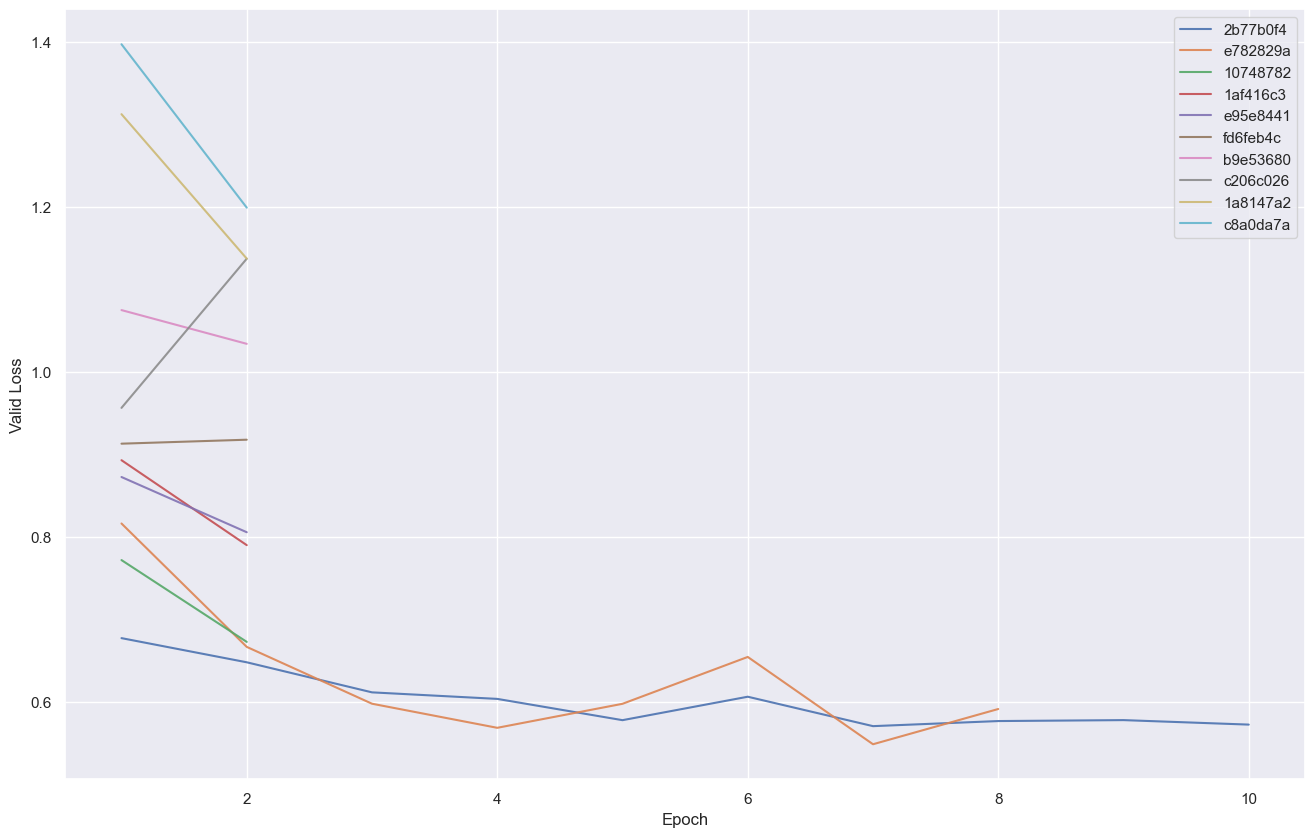

In [24]:
# Plot trials valid loss

cnn_raytune.plot_trials_loss(
	dataframe  = trials,
	max_trials = 10,
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, core_config['model_name'] + '-trials')
)

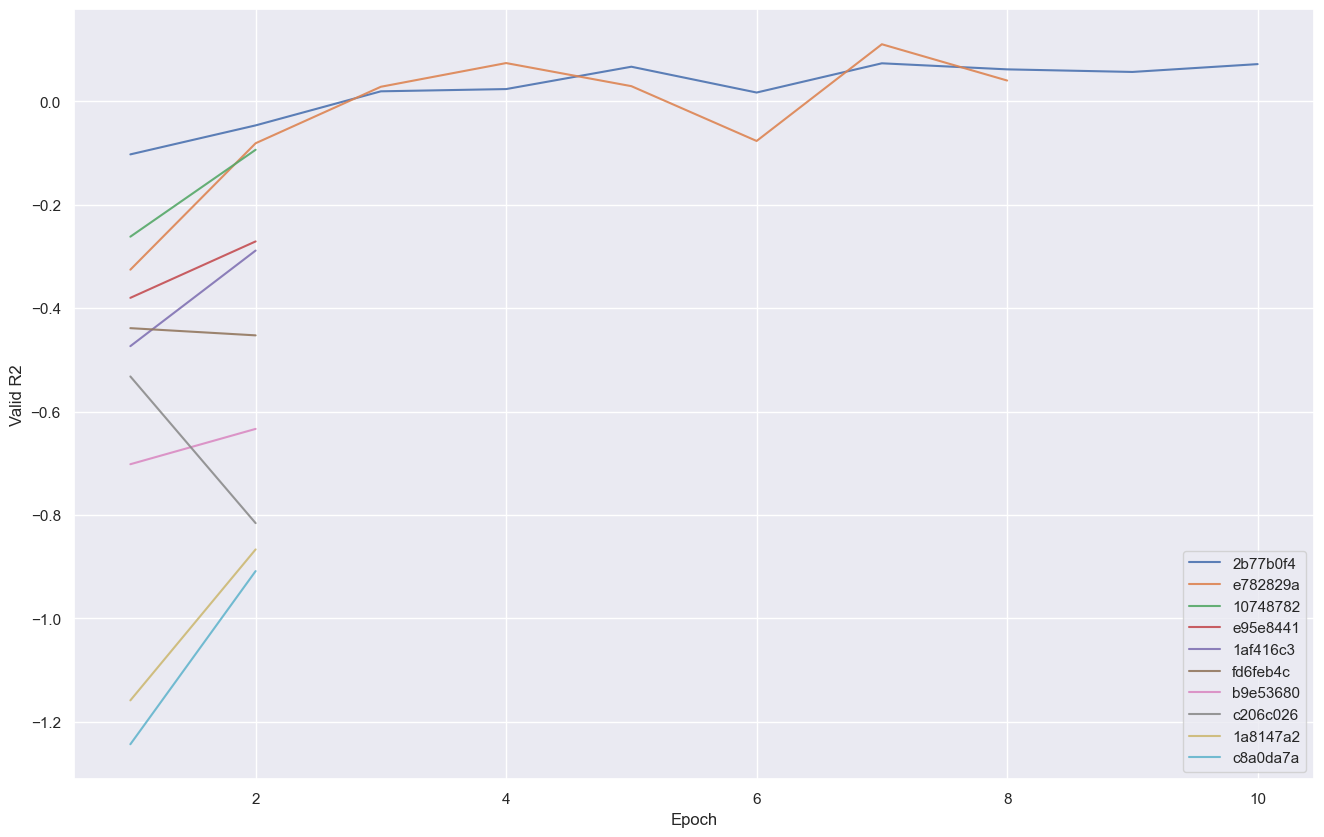

In [25]:
# Plot trials valid r2

cnn_raytune.plot_trials_r2(
	dataframe  = trials,
	max_trials = 10,
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, core_config['model_name'] + '-trials')
)

### 2.4.2 Best

In [26]:
# Display best trial

best = report.get_best_result()

print('Best metric : loss = {: 8.5f} r2 = {: 8.5f}'.format(best.metrics['valid_loss'], best.metrics['valid_r2']))
print('Best config : ')

for key, val in best.config.items() :
	if isinstance(key, str) : key = f'"{key}"'
	if isinstance(val, str) : val = f'"{val}"'

	print('{:30s} : {}'.format(key, val))

Best metric : loss =  0.57214 r2 =  0.07187
Best config : 
"dataset/batch_size"           : 32
"optimizer/name"               : "adam"
"optimizer/lr"                 : 3.262648825129617e-05
"optimizer/decay"              : 0.05530820765433695
"optimizer/momentum"           : 0.5857655085105684
"scheduler/name"               : "constant"
"scheduler/plateau/factor"     : 0.3798409889797759
"scheduler/plateau/patience"   : 4
"scheduler/linear/factor"      : 0.004318109387491916
"scheduler/step/factor"        : 0.16975929027771253
"scheduler/step/patience"      : 11
"scheduler/exponential/factor" : 0.9652544464799763
"model/dropout"                : 0.02
"model/conv1/filters"          : 32
"model/conv1/kernel"           : 11
"model/conv1/padding"          : "none"
"model/conv1/dilation"         : 1
"model/conv2/filters"          : 32
"model/conv2/kernel"           : 31
"model/conv2/padding"          : "same"
"model/conv2/dilation"         : 1
"model/conv3/filters"          : 64
"model/conv

In [27]:
# Display per iteration

progress = data_loader.load_csv(
	filename = os.path.join(best.log_dir, 'progress.csv')
)

progress = progress[['trial_id', 'experiment_id', 'time_total_s', 'training_iteration', 'lr', 'valid_loss', 'valid_r2', 'valid_mae', 'train_loss']]
progress

,trial_id,experiment_id,time_total_s,training_iteration,lr,valid_loss,valid_r2,valid_mae,train_loss
0,2b77b0f4,9dd993838202410e83c60e1fb5dd13bd,51.028,1,0.000,0.677,-0.103,0.681,0.909
1,2b77b0f4,9dd993838202410e83c60e1fb5dd13bd,64.971,2,0.000,0.648,-0.047,0.669,0.671
2,2b77b0f4,9dd993838202410e83c60e1fb5dd13bd,79.036,3,0.000,0.611,0.019,0.651,0.627
3,2b77b0f4,9dd993838202410e83c60e1fb5dd13bd,92.997,4,0.000,0.603,0.024,0.645,0.598
4,2b77b0f4,9dd993838202410e83c60e1fb5dd13bd,106.851,5,0.000,0.578,0.067,0.632,0.576
5,2b77b0f4,9dd993838202410e83c60e1fb5dd13bd,120.711,6,0.000,0.606,0.017,0.645,0.556
6,2b77b0f4,9dd993838202410e83c60e1fb5dd13bd,134.610,7,0.000,0.570,0.073,0.625,0.540
7,2b77b0f4,9dd993838202410e83c60e1fb5dd13bd,148.572,8,0.000,0.576,0.062,0.628,0.521
8,2b77b0f4,9dd993838202410e83c60e1fb5dd13bd,162.434,9,0.000,0.578,0.057,0.627,0.502
9,2b77b0f4,9dd993838202410e83c60e1fb5dd13bd,176.304,10,0.000,0.572,0.072,0.624,0.476


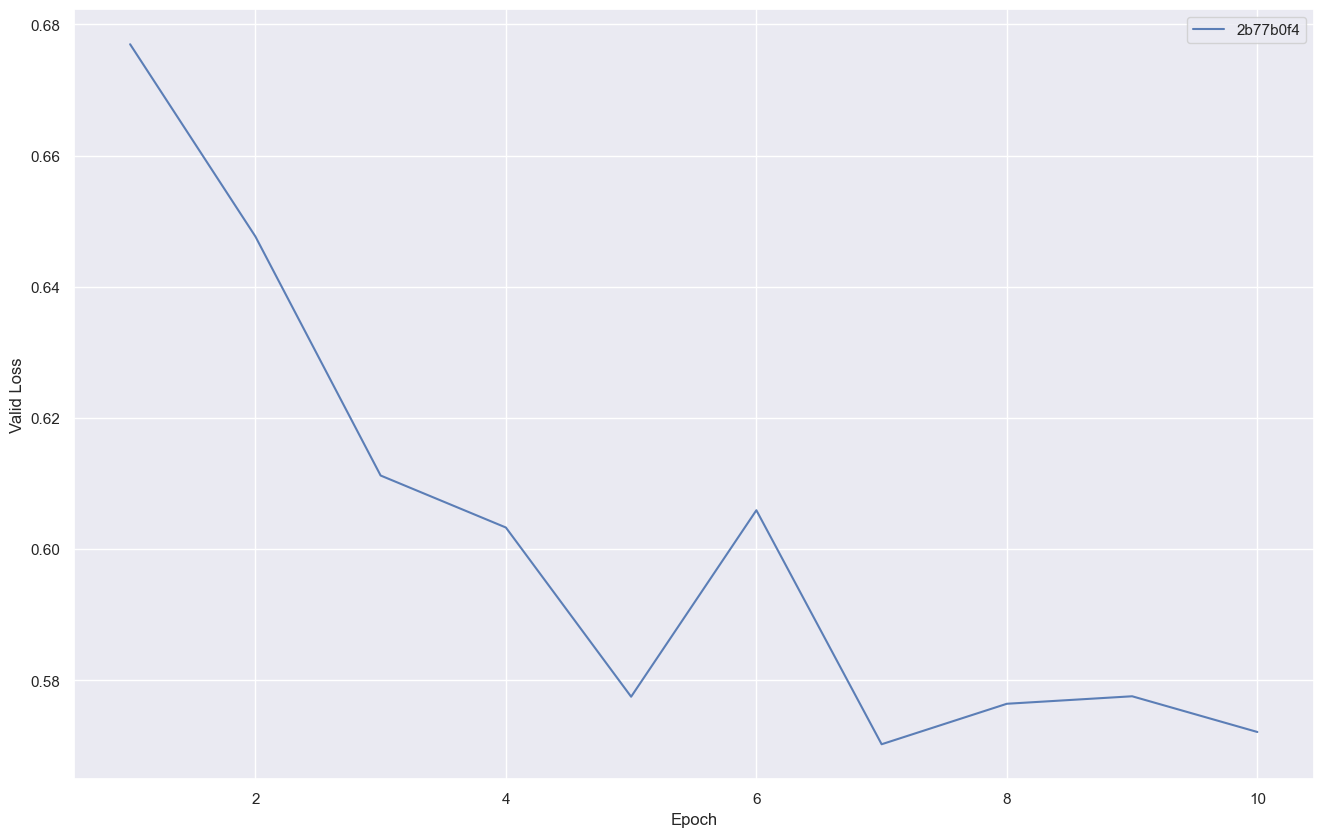

In [28]:
# Plot best trial valid loss

cnn_raytune.plot_trial_loss(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, core_config['model_name'] + '-best')
)

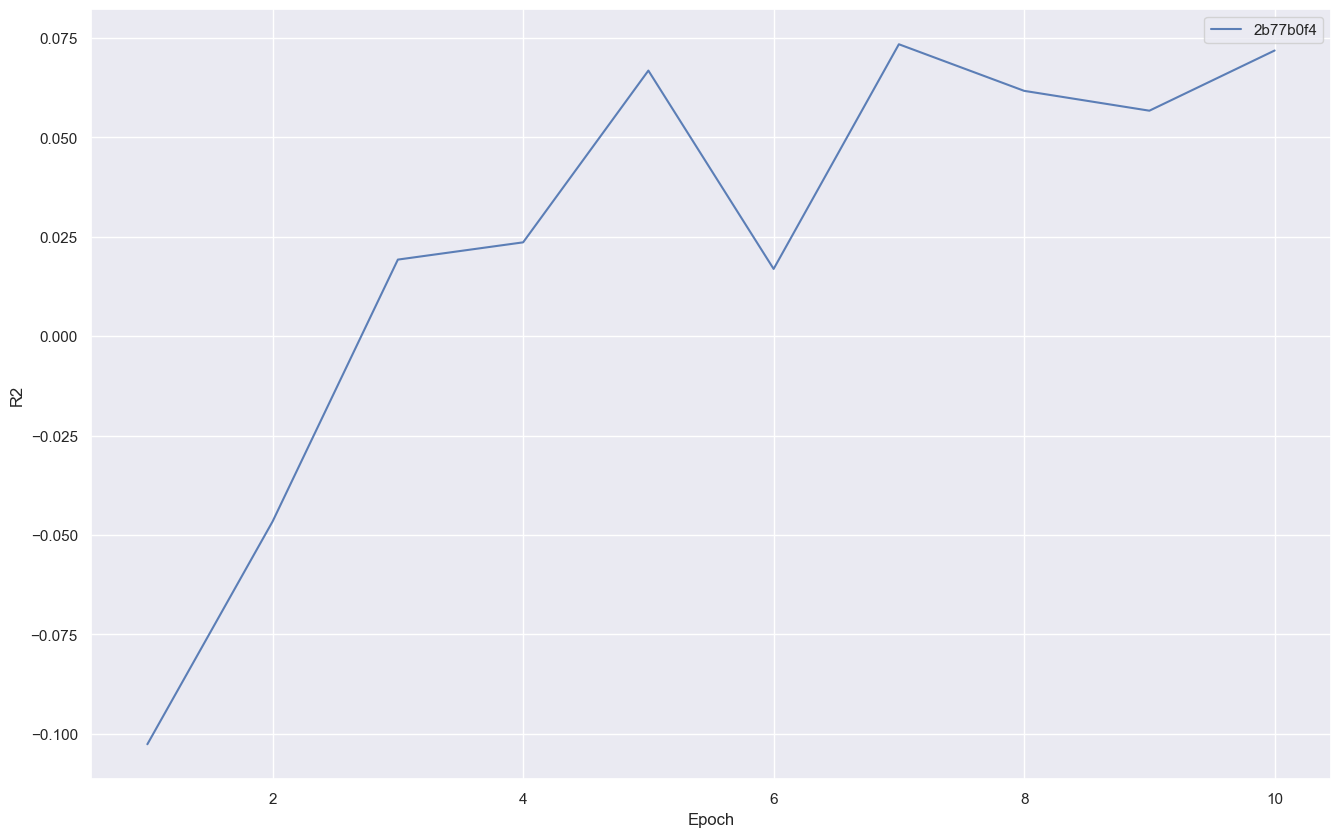

In [29]:
# Plot best trial valid r2

cnn_raytune.plot_trial_r2(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, core_config['model_name'] + '-best')
)

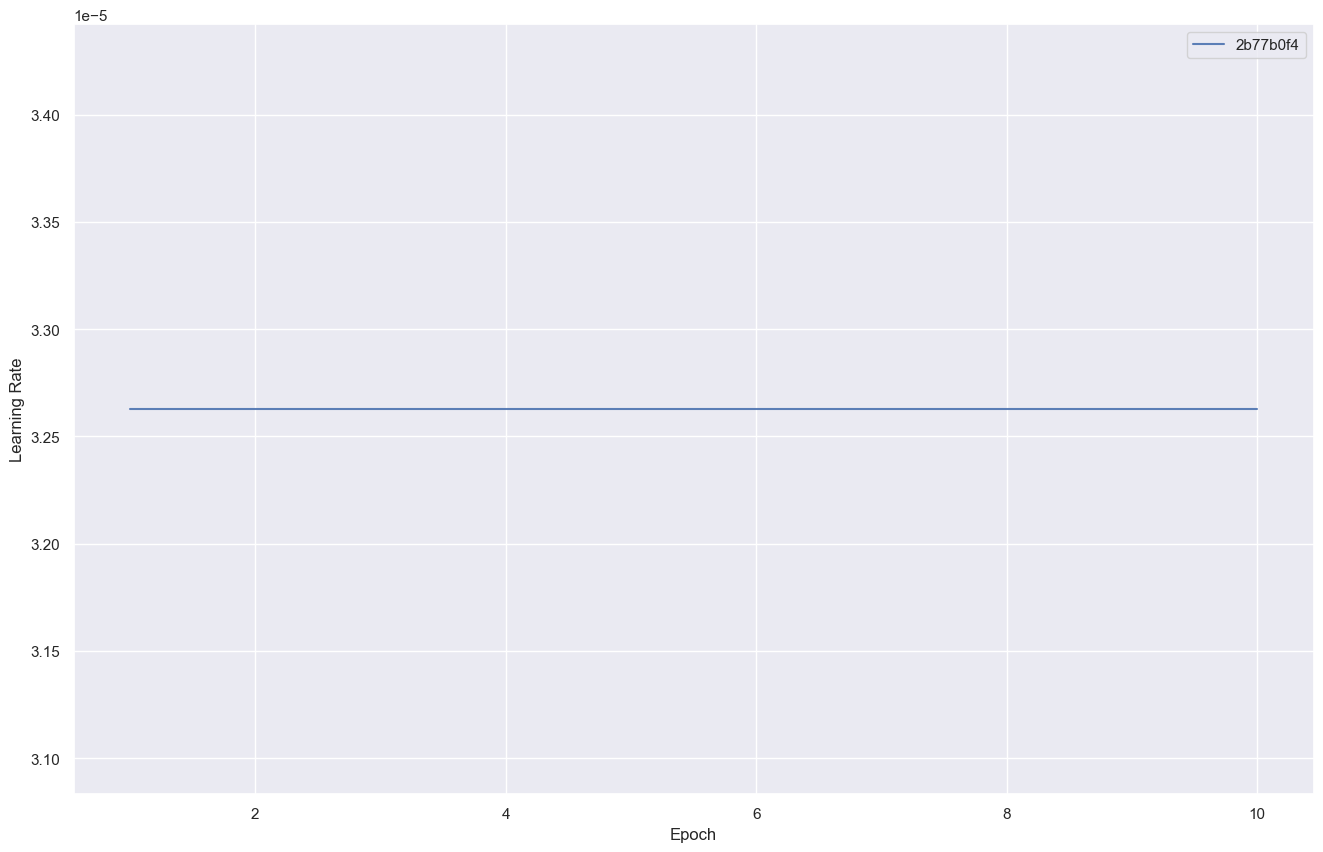

In [30]:
# Plot trials learning rate

cnn_raytune.plot_trial_lr(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, core_config['model_name'] + '-best')
)

### 2.4.3 Worst

In [31]:
# Display worst trial

worst = report.get_best_result(metric = 'valid_loss', mode = 'max')

print('Worst metric : loss = {: 8.5f} r2 = {: 8.5f}'.format(worst.metrics['valid_loss'], worst.metrics['valid_r2']))
print('Worst config : ')

for key, val in best.config.items() :
	if isinstance(key, str) : key = f'"{key}"'
	if isinstance(val, str) : val = f'"{val}"'

	print('{:30s} : {}'.format(key, val))

Worst metric : loss =  664372.03034 r2 = -1084942.76530
Worst config : 
"dataset/batch_size"           : 32
"optimizer/name"               : "adam"
"optimizer/lr"                 : 3.262648825129617e-05
"optimizer/decay"              : 0.05530820765433695
"optimizer/momentum"           : 0.5857655085105684
"scheduler/name"               : "constant"
"scheduler/plateau/factor"     : 0.3798409889797759
"scheduler/plateau/patience"   : 4
"scheduler/linear/factor"      : 0.004318109387491916
"scheduler/step/factor"        : 0.16975929027771253
"scheduler/step/patience"      : 11
"scheduler/exponential/factor" : 0.9652544464799763
"model/dropout"                : 0.02
"model/conv1/filters"          : 32
"model/conv1/kernel"           : 11
"model/conv1/padding"          : "none"
"model/conv1/dilation"         : 1
"model/conv2/filters"          : 32
"model/conv2/kernel"           : 31
"model/conv2/padding"          : "same"
"model/conv2/dilation"         : 1
"model/conv3/filters"          : 6

In [32]:
# Display per iteration

progress = data_loader.load_csv(
	filename = os.path.join(worst.log_dir, 'progress.csv')
)

progress = progress[['trial_id', 'experiment_id', 'time_total_s', 'training_iteration', 'lr', 'valid_loss', 'valid_r2', 'valid_mae', 'train_loss']]
progress

,trial_id,experiment_id,time_total_s,training_iteration,lr,valid_loss,valid_r2,valid_mae,train_loss
0,e89cb8f3,85655fcd742340788200b8c887c8a6f7,86.177,1,0.002,9101537.615,-14828412.584,2360.956,1.260
1,e89cb8f3,85655fcd742340788200b8c887c8a6f7,134.816,2,0.002,664372.030,-1084942.765,690.263,0.685


## 2.5 Save

In [33]:
# Save the tuning results

report.get_dataframe().to_csv(
	os.path.join(OUT_DATA, core_config['model_name'] + '-report.csv')
)